In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load feature 4 (S4 and S123 contacts) 

In [4]:
with np.load("../../data/raw_feat/feat4_raw.npz", allow_pickle=True) as f:
    data_arr = f["arr_0"]

In [5]:
print(len(data_arr))
print(data_arr[0].shape)

6580000
(1924,)


In [6]:
data_arr = np.concatenate(data_arr)
print(data_arr.shape)

(6580000, 1924)


In [7]:
# convert to binary matrix
data_arr = data_arr.astype(np.byte)

In [12]:
np.savez("../../data/raw_feat/feat4_raw.npz", data_arr)

In [16]:
# array is very sparse, mostly 0s
np.count_nonzero(data_arr)

187212490

In [17]:
187212490 / (6580000 * 1924)

0.014787809875575833

In [8]:
np.mean(data_arr)

0.014787809875575833

## load CVs 

In [6]:
with np.load("../../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [10]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
cv_trajs = np.split(cv_arr, traj_inds)

NameError: name 'data' is not defined

In [7]:
cv_arr.shape

(6580000, 2)

In [14]:
# take only last 30 features (Cz - Cd distances)
data_cz = [traj[:, 30:] for traj in data]

NameError: name 'data' is not defined

## Models 

In [ ]:
feat4 = pyemma.coordinates.featurizer(
    "../../models/Initial-models/civsd-down-minus.pdb"
)

## Load IVAC data

Load New version using Gaussian contact-transformed distances (4.26.21)

In [8]:
livac_trajs = np.load("../../data/sb-livac-gauss.npy", allow_pickle=True)
print(livac_trajs.shape)
livac_arr = np.concatenate(livac_trajs)
print(livac_arr.shape)
models_livac = np.load("../../data/models-livac-gauss.npy")

(1295,)
(6580000, 5)


# New states (with iTIC cutoffs)

In [9]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]

# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 (1 sigma in each direction) for down- state
# take points where TIC 1 < -1
dist_ax_down = (dist + 8.919) / 0.632
rot_ax_down = (rot + 109.9) / 9.8
downmin_ids = (((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (tic1 < -1.0)).nonzero()[
    0
]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 > 1.1
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 > 1.2)).nonzero()[0]

In [12]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[downmin_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cv_arr[downmin_ids]
upplus_cvs = cv_arr[upplus_ids]
other_cvs = cv_arr[mask]

In [13]:
assert (len(downmin) + len(upplus) + len(other)) == len(cv_arr)
print(f"Number of down- structures:  {len(downmin)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down- structures:  1355
Number of up+ structures:   53027
Number of other structures: 6525618


# Distances 

In [19]:
%matplotlib inline

In [20]:
print(sklearn.get_config()["working_memory"])

1024


In [21]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [22]:
d_downmin = []
counter = 0.0
tot = len(data_arr)
skip = 3

for chunk in metrics.pairwise_distances_chunked(
    data_arr, downmin[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_downmin.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

4.51% completed
9.03% completed
13.54% completed
18.05% completed
22.56% completed
27.08% completed
31.59% completed
36.10% completed
40.62% completed
45.13% completed
49.64% completed
54.15% completed
58.67% completed
63.18% completed
67.69% completed
72.20% completed
76.72% completed
81.23% completed
85.74% completed
90.26% completed
94.77% completed
99.28% completed
100.00% completed


In [23]:
print(len(d_downmin), d_downmin[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_downmin_arr = np.reshape(np.concatenate(d_downmin), (-1, 1))
print(d_downmin_arr.shape)
print(np.max(d_downmin_arr[downmin_ids]))
d_downmin_arr[downmin_ids] = 0
print(np.max(d_downmin_arr[downmin_ids]))

print(d_downmin_arr.shape)

23 (296941,)
(6580000, 1)
3.1622776601683795
0.0
(6580000, 1)


In [24]:
np.save("../../data/feat4_dduu/dist_downmin_dduu_feat4", d_downmin_arr)

## Up+state

In [25]:
d_upp = []
counter = 0.0
skip = 3

for chunk in metrics.pairwise_distances_chunked(
    data_arr, upplus[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_upp.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.12% completed
0.23% completed
0.35% completed
0.46% completed
0.58% completed
0.69% completed
0.81% completed
0.92% completed
1.04% completed
1.15% completed
1.27% completed
1.38% completed
1.50% completed
1.62% completed
1.73% completed
1.85% completed
1.96% completed
2.08% completed
2.19% completed
2.31% completed
2.42% completed
2.54% completed
2.65% completed
2.77% completed
2.88% completed
3.00% completed
3.12% completed
3.23% completed
3.35% completed
3.46% completed
3.58% completed
3.69% completed
3.81% completed
3.92% completed
4.04% completed
4.15% completed
4.27% completed
4.39% completed
4.50% completed
4.62% completed
4.73% completed
4.85% completed
4.96% completed
5.08% completed
5.19% completed
5.31% completed
5.42% completed
5.54% completed
5.65% completed
5.77% completed
5.89% completed
6.00% completed
6.12% completed
6.23% completed
6.35% completed
6.46% completed
6.58% completed
6.69% completed
6.81% completed
6.92% completed
7.04% completed
7.15% completed
7.27% co

In [26]:
print(len(d_upp), d_upp[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_upp_arr = np.reshape(np.concatenate(d_upp), (-1, 1))
print(d_upp_arr.shape)
print(np.max(d_upp_arr[upplus_ids]))
d_upp_arr[upplus_ids] = 0
print(np.max(d_upp_arr[upplus_ids]))

print(d_upp_arr.shape)

867 (7593,)
(6580000, 1)
3.605551275463989
0.0
(6580000, 1)


In [27]:
np.save("../../data/feat4_dduu/dist_upp_dduu_feat4.npy", d_upp_arr)

In [10]:
d_downmin_arr = np.load("../../data/feat4_dduu/dist_downmin_dduu_feat4.npy")
d_upp_arr = np.load("../../data/feat4_dduu/dist_upp_dduu_feat4.npy")

# Smoothing and guess functions 

In [14]:
# make smoothing function
smooth = (d_downmin_arr * d_upp_arr) ** 0.5 / (d_downmin_arr + d_upp_arr)

# make guess
guess_downmin = (d_upp_arr / (d_downmin_arr + d_upp_arr)) ** 2
guess_upp = (d_downmin_arr / (d_downmin_arr + d_upp_arr)) ** 2

# make smoothing 0 at boundaries (dimer and monomer states)
smooth[(mask == 0).flatten()] = 0
# ensure homogeneous boundary conditions for guess
guess_upp[upplus_ids] = 1
guess_upp[downmin_ids] = 0
guess_downmin[downmin_ids] = 1
guess_downmin[upplus_ids] = 0

In [15]:
print(smooth.shape, guess_downmin.shape, guess_upp.shape)

(6580000, 1) (6580000, 1) (6580000, 1)


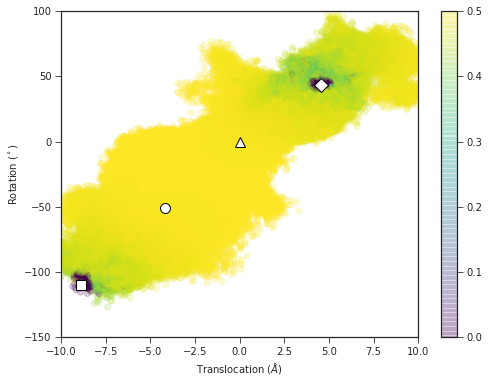

In [30]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=smooth[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

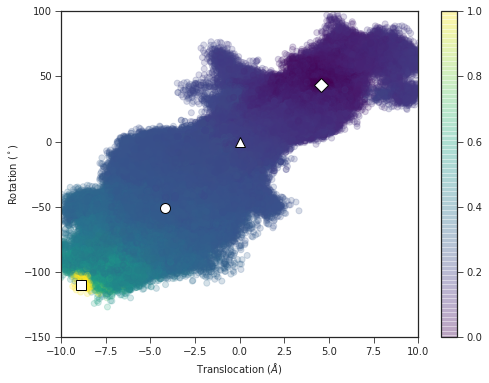

In [31]:
# Plot down state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_downmin[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

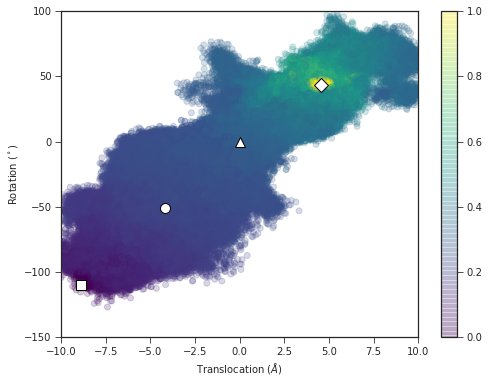

In [32]:
# Plot up+ state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_upp[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

# Construct bases 

In [16]:
from scipy import sparse

In [20]:
def svd_whiten(X, k=500, frac_retain=1.0):
    # sparse
    U, L, V = sparse.linalg.svds(X, k=k, which="LM")
    s = np.cumsum(L) / np.sum(L)
    n = np.where(s >= frac_retain)[0][0]
    return (U @ V)[:, 0:n], L

In [34]:
basis_smooth = smooth * data_arr
print(basis_smooth.shape)
basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=0.75)
basis_white[(mask == 0).flatten()] = 0

(6580000, 1924)


MemoryError: Unable to allocate 94.3 GiB for an array with shape (6580000, 1924) and data type float64

In [18]:
basis_smooth = smooth * data_arr
basis_smooth_sp = sparse.csr_matrix(basis_smooth)

In [ ]:
basis_white_sp, L = svd_whiten(basis_smooth_sp, k=500)

In [ ]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
h2 = ax2.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=basis_white[::10, :].mean(axis=1),
    alpha=0.1,
    cmap="viridis",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Whitened basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

In [ ]:
np.save("../../data/feat4_dduu/basis_white_dduu_feat4.npy", basis_white)
np.save("../../data/feat4_dduu/guess_down_dduu_feat4.npy", guess_downmin)
np.save("../../data/feat4_dduu/guess_up_dduu_feat4.npy", guess_upp)

## Convert to lists of np arrays 

In [ ]:
const = np.ones((len(data_arr), 1))
basisL_arr = np.hstack((const, data_arr))
basisF_arr = basis_white

# basisL = np.split(basisL_arr, traj_inds)
basisL = np.split(data_arr, traj_inds)
basisF = np.split(basisF_arr, traj_inds)
guessU = np.split(np.squeeze(guess_upp), traj_inds)
guessD = np.split(np.squeeze(guess_downmin), traj_inds)

print(len(basisL), basisL[0].shape)
print(len(basisF), basisF[0].shape)
print(len(guessU))
print(len(guessD))

In [ ]:
# convert to sparse matrices
basisF_sp = [sparse.csr_matrix(basis) for basis in basisF]
guessU_sp = [sparse.csr_matrix(guess) for guess in guessU]
guessD_sp = [sparse.csr_matrix(guess) for guess in guessD]